# GNNs

## mass into account

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GeneralConv, GENConv
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from datagen import generate_dataset, generate_dataset_nbodies, generate_dataset_1gal
from tqdm import tqdm



def fully_connected(input_dim, hidden_dim, output_dim, num_layers):
    layers = []
    # Add hidden layers
    for _ in range(num_layers):
        layers.append(torch.nn.Linear(input_dim, hidden_dim))
        layers.append(torch.nn.ReLU())
        input_dim = hidden_dim
    # Add output layer
    layers.append(torch.nn.Linear(hidden_dim, output_dim))
    return torch.nn.Sequential(*layers)

# Function to create edge weights based on mass difference
def create_edge_attributes_based_on_mass_and_dist(data):
    row, col = data.edge_index  # Get indices of connected nodes
    # Get masses for each node in the connection
    pos_row = data.x[row][:, :3]
    pos_col = data.x[col][:, :3]
    distance = torch.norm(pos_row - pos_col, dim=1)  # Calculate distance between nodes
    mass_row = data.x[row][:, -1]
    mass_col = data.x[col][:, -1]
    mass_prod = mass_row * mass_col  # Multiply masses
    data.edge_attr = torch.stack([mass_prod, distance], dim=1)  # Concatenate edge attributes
    
    return data

class ParticleGNN(torch.nn.Module):
    def __init__(self, input_dim, fc_dim, fc_layers, gnn_dim, message_passing_steps, output_dim):
        super(ParticleGNN, self).__init__()
        # Encoder for initial node features
        self.encoder = fully_connected(input_dim, fc_dim, gnn_dim, fc_layers)
        # GeneralConv layers for message passing
        self.gnns = []
        for i in range(message_passing_steps):
            gnn = GENConv(in_channels=gnn_dim, out_channels=gnn_dim, aggr='add', edge_dim=2)
            setattr(self, f'gnn_{i}', gnn)
            self.gnns.append(gnn)
        
        # Decoder to transform final node features to output
        self.decoder = fully_connected(gnn_dim, fc_dim, output_dim, fc_layers)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr  # Use edge_attr instead of edge_weight
        x = self.encoder(x)
        
        for gnn in self.gnns:
            x = F.relu(gnn(x, edge_index, edge_attr=edge_attr))  # Pass edge_attr to GeneralConv
        
        x = self.decoder(x)
        return x



# Function to convert particles to a torch_geometric Data object
def transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, radius):
    # Extract features for each particle: [x, y, z, vx, vy, vz, mass]

    
    # Create edges based on radius
    edge_index = radius_graph(positions, r=radius)
    # for every node, connect it to top 2 biggest nodes
    '''
    biggest_nodes_index = torch.argsort(features[:, -1], descending=True)[:2]
    for i in range(features.shape[0]):
        if i not in biggest_nodes_index:
            edge_index = torch.cat((edge_index, torch.tensor([[i, biggest_nodes_index[0]], [i, biggest_nodes_index[1]]], dtype=torch.long)), 1)
            edge_index = torch.cat((edge_index, torch.tensor([[biggest_nodes_index[0], i], [biggest_nodes_index[1], i]], dtype=torch.long)), 1)
    '''


    
    # Create data object
    graph_data = Data(x=features, edge_index=edge_index)
    
    # Add edge weights based on mass
    graph_data = create_edge_attributes_based_on_mass_and_dist(graph_data)
    return graph_data



  


In [2]:
def euclidean_distance(a, b):
    return torch.sqrt(torch.sum((a - b)**2, dim=-1) + 1e-12)
def mean_distance(a, b):
    return torch.mean(euclidean_distance(a, b))

In [3]:
import torch
def generate_graph_dataset(data, radius):
    graphs = []
    for i in tqdm(range(len(data))):
        masses = torch.tensor(data[i]['masses']).unsqueeze(-1)
        positions = torch.tensor(data[i]['pos'])
        velocities = torch.tensor(data[i]['vel'])
        Gs = torch.ones_like(masses) 
        softening = torch.ones_like(masses) * 0.1
        features = torch.cat([positions, velocities, Gs, softening, masses], dim=-1)
        graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, radius)
        graph_data.y = torch.tensor(data[i]['acc'])
        graphs.append(graph_data)
    return graphs

In [4]:
# Initialize model and optimizer
import os
model = ParticleGNN(input_dim=9, fc_dim=256, fc_layers=2, gnn_dim=256, message_passing_steps=5, output_dim=3)
# load model weights
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device)
#model.load_state_dict(torch.load('./models/'+sorted(os.listdir('models'), key=lambda x: int(x.split('.')[0].split('_')[-1]))[-1], map_location=torch.device(device)))


In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:


ROUNDS = 50
EPOCHS = 4
SCENES = 10
WINDOW_SIZE = 0
N_BODIES = 3
BATCH_SIZE = 64
RADIUS = 1.0


# Training loop
model.train()
for r in range(ROUNDS):
    print(f'--- Round {r} ---')
    data = generate_dataset_1gal(n_scenes=SCENES, window_size=WINDOW_SIZE)
    print('Converting to graphs...')
    graphs = generate_graph_dataset(data, RADIUS)
    dataloader = DataLoader(graphs, batch_size=BATCH_SIZE)
    print('Training...')
    for epoch in range(EPOCHS):
        epoch_losses = []
        print(f'Epoch {epoch+1}')
        for data in tqdm(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = mean_distance(out, data.y)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            del data
            torch.cuda.empty_cache()
        print(f'Epoch {epoch+1}, Loss: {torch.tensor(epoch_losses).mean()}')
    del graphs, dataloader
    torch.cuda.empty_cache()
    if (r+1) % 10 == 0:
        print('Saving model...')
        torch.save(model.state_dict(), f'./models/particle_gnn_{r}.pth')
    







--- Round 0 ---
Generating dataset with 10 scenes...


100%|██████████| 10/10 [03:05<00:00, 18.55s/it]


Converting to graphs...


100%|██████████| 9760/9760 [00:50<00:00, 192.92it/s]


Training...
Epoch 1


100%|██████████| 153/153 [01:03<00:00,  2.41it/s]


Epoch 1, Loss: 1.5435205698013306
Epoch 2


100%|██████████| 153/153 [01:02<00:00,  2.43it/s]


Epoch 2, Loss: 1.424235463142395
Epoch 3


100%|██████████| 153/153 [01:03<00:00,  2.40it/s]


Epoch 3, Loss: 1.3902779817581177
Epoch 4


100%|██████████| 153/153 [01:03<00:00,  2.42it/s]


Epoch 4, Loss: 1.3610589504241943
--- Round 1 ---
Generating dataset with 10 scenes...


100%|██████████| 10/10 [03:07<00:00, 18.77s/it]


Converting to graphs...


100%|██████████| 9760/9760 [00:50<00:00, 193.14it/s]


Training...
Epoch 1


100%|██████████| 153/153 [01:01<00:00,  2.48it/s]


Epoch 1, Loss: 1.548606514930725
Epoch 2


100%|██████████| 153/153 [01:01<00:00,  2.51it/s]


Epoch 2, Loss: 1.409324288368225
Epoch 3


100%|██████████| 153/153 [01:01<00:00,  2.50it/s]


Epoch 3, Loss: 1.3550398349761963
Epoch 4


100%|██████████| 153/153 [01:01<00:00,  2.48it/s]


Epoch 4, Loss: 1.314544916152954
--- Round 2 ---
Generating dataset with 10 scenes...


100%|██████████| 10/10 [03:11<00:00, 19.10s/it]


Converting to graphs...


100%|██████████| 9760/9760 [00:50<00:00, 193.45it/s]


Training...
Epoch 1


100%|██████████| 153/153 [01:01<00:00,  2.47it/s]


Epoch 1, Loss: 1.5393105745315552
Epoch 2


100%|██████████| 153/153 [01:01<00:00,  2.50it/s]


Epoch 2, Loss: 1.344801902770996
Epoch 3


100%|██████████| 153/153 [01:01<00:00,  2.50it/s]


Epoch 3, Loss: 1.2906814813613892
Epoch 4


100%|██████████| 153/153 [01:01<00:00,  2.50it/s]


Epoch 4, Loss: 1.2423913478851318
--- Round 3 ---
Generating dataset with 10 scenes...


100%|██████████| 10/10 [03:10<00:00, 19.06s/it]


Converting to graphs...


100%|██████████| 9760/9760 [00:50<00:00, 193.55it/s]


Training...
Epoch 1


100%|██████████| 153/153 [01:01<00:00,  2.47it/s]


Epoch 1, Loss: 1.443070650100708
Epoch 2


100%|██████████| 153/153 [01:02<00:00,  2.43it/s]


Epoch 2, Loss: 1.2477878332138062
Epoch 3


100%|██████████| 153/153 [01:02<00:00,  2.43it/s]


Epoch 3, Loss: 1.1760016679763794
Epoch 4


100%|██████████| 153/153 [01:03<00:00,  2.41it/s]


Epoch 4, Loss: 1.1181073188781738
--- Round 4 ---
Generating dataset with 10 scenes...


100%|██████████| 10/10 [03:05<00:00, 18.53s/it]


Converting to graphs...


100%|██████████| 9760/9760 [00:50<00:00, 193.01it/s]


Training...
Epoch 1


100%|██████████| 153/153 [01:04<00:00,  2.36it/s]


Epoch 1, Loss: 1.3850594758987427
Epoch 2


100%|██████████| 153/153 [01:02<00:00,  2.45it/s]


Epoch 2, Loss: 1.1343835592269897
Epoch 3


100%|██████████| 153/153 [01:04<00:00,  2.38it/s]


Epoch 3, Loss: 1.0570895671844482
Epoch 4


100%|██████████| 153/153 [01:03<00:00,  2.41it/s]


Epoch 4, Loss: 1.011103868484497
--- Round 5 ---
Generating dataset with 10 scenes...


100%|██████████| 10/10 [03:04<00:00, 18.49s/it]


Converting to graphs...


100%|██████████| 9760/9760 [00:50<00:00, 192.91it/s]


Training...
Epoch 1


100%|██████████| 153/153 [01:03<00:00,  2.40it/s]


Epoch 1, Loss: 1.216896414756775
Epoch 2


100%|██████████| 153/153 [01:03<00:00,  2.40it/s]


Epoch 2, Loss: 1.0357353687286377
Epoch 3


100%|██████████| 153/153 [01:04<00:00,  2.38it/s]


Epoch 3, Loss: 0.9869548082351685
Epoch 4


100%|██████████| 153/153 [01:02<00:00,  2.43it/s]


Epoch 4, Loss: 0.9534866213798523
--- Round 6 ---
Generating dataset with 10 scenes...


100%|██████████| 10/10 [03:03<00:00, 18.32s/it]


Converting to graphs...


100%|██████████| 9760/9760 [00:50<00:00, 192.79it/s]


Training...
Epoch 1


100%|██████████| 153/153 [01:02<00:00,  2.44it/s]


Epoch 1, Loss: 1.2334308624267578
Epoch 2


100%|██████████| 153/153 [01:03<00:00,  2.41it/s]


Epoch 2, Loss: 1.019628882408142
Epoch 3


100%|██████████| 153/153 [01:03<00:00,  2.40it/s]


Epoch 3, Loss: 0.9693412184715271
Epoch 4


100%|██████████| 153/153 [01:02<00:00,  2.44it/s]


Epoch 4, Loss: 0.9361802935600281
--- Round 7 ---
Generating dataset with 10 scenes...


100%|██████████| 10/10 [03:05<00:00, 18.59s/it]


Converting to graphs...


100%|██████████| 9760/9760 [00:50<00:00, 191.40it/s]


Training...
Epoch 1


100%|██████████| 153/153 [01:04<00:00,  2.39it/s]


Epoch 1, Loss: 1.1501615047454834
Epoch 2


100%|██████████| 153/153 [01:02<00:00,  2.44it/s]


Epoch 2, Loss: 0.9644132852554321
Epoch 3


100%|██████████| 153/153 [01:03<00:00,  2.40it/s]


Epoch 3, Loss: 0.9187138080596924
Epoch 4


100%|██████████| 153/153 [01:02<00:00,  2.44it/s]


Epoch 4, Loss: 0.8875837922096252
--- Round 8 ---
Generating dataset with 10 scenes...


100%|██████████| 10/10 [03:04<00:00, 18.47s/it]


Converting to graphs...


100%|██████████| 9760/9760 [00:51<00:00, 191.17it/s]


Training...
Epoch 1


100%|██████████| 153/153 [01:03<00:00,  2.40it/s]


Epoch 1, Loss: 1.1640044450759888
Epoch 2


100%|██████████| 153/153 [01:03<00:00,  2.42it/s]


Epoch 2, Loss: 0.9510433077812195
Epoch 3


100%|██████████| 153/153 [01:02<00:00,  2.45it/s]


Epoch 3, Loss: 0.894831657409668
Epoch 4


100%|██████████| 153/153 [01:02<00:00,  2.46it/s]


Epoch 4, Loss: 0.8530073761940002
--- Round 9 ---
Generating dataset with 10 scenes...


100%|██████████| 10/10 [03:12<00:00, 19.26s/it]


Converting to graphs...


100%|██████████| 9760/9760 [00:50<00:00, 192.62it/s]


Training...
Epoch 1


100%|██████████| 153/153 [01:02<00:00,  2.44it/s]


Epoch 1, Loss: 1.0546261072158813
Epoch 2


100%|██████████| 153/153 [01:02<00:00,  2.45it/s]


Epoch 2, Loss: 0.8445543050765991
Epoch 3


100%|██████████| 153/153 [01:02<00:00,  2.44it/s]


Epoch 3, Loss: 0.7718608379364014
Epoch 4


100%|██████████| 153/153 [01:02<00:00,  2.44it/s]


Epoch 4, Loss: 0.712269127368927
Saving model...
--- Round 10 ---
Generating dataset with 10 scenes...


100%|██████████| 10/10 [03:25<00:00, 20.59s/it]


Converting to graphs...


100%|██████████| 9760/9760 [00:51<00:00, 190.25it/s]


Training...
Epoch 1


100%|██████████| 153/153 [01:03<00:00,  2.42it/s]


Epoch 1, Loss: 0.964978814125061
Epoch 2


100%|██████████| 153/153 [01:02<00:00,  2.46it/s]


Epoch 2, Loss: 0.7223986387252808
Epoch 3


100%|██████████| 153/153 [01:01<00:00,  2.49it/s]


Epoch 3, Loss: 0.6462892293930054
Epoch 4


100%|██████████| 153/153 [01:01<00:00,  2.50it/s]


Epoch 4, Loss: 0.5980917811393738
--- Round 11 ---
Generating dataset with 10 scenes...


100%|██████████| 10/10 [03:12<00:00, 19.21s/it]


Converting to graphs...


100%|██████████| 9760/9760 [00:50<00:00, 194.13it/s]


Training...
Epoch 1


100%|██████████| 153/153 [01:02<00:00,  2.47it/s]


Epoch 1, Loss: 0.7730070352554321
Epoch 2


100%|██████████| 153/153 [01:01<00:00,  2.50it/s]


Epoch 2, Loss: 0.5813117027282715
Epoch 3


100%|██████████| 153/153 [01:01<00:00,  2.50it/s]


Epoch 3, Loss: 0.5297150015830994
Epoch 4


100%|██████████| 153/153 [01:01<00:00,  2.50it/s]


Epoch 4, Loss: 0.4963585436344147
--- Round 12 ---
Generating dataset with 10 scenes...


100%|██████████| 10/10 [03:11<00:00, 19.18s/it]


Converting to graphs...


100%|██████████| 9760/9760 [00:50<00:00, 193.37it/s]


Training...
Epoch 1


100%|██████████| 153/153 [01:02<00:00,  2.46it/s]


Epoch 1, Loss: 0.8527288436889648
Epoch 2


100%|██████████| 153/153 [01:01<00:00,  2.49it/s]


Epoch 2, Loss: 0.5793946981430054
Epoch 3


100%|██████████| 153/153 [01:01<00:00,  2.49it/s]


Epoch 3, Loss: 0.5245115756988525
Epoch 4


100%|██████████| 153/153 [01:01<00:00,  2.49it/s]


Epoch 4, Loss: 0.49290990829467773
--- Round 13 ---
Generating dataset with 10 scenes...


100%|██████████| 10/10 [03:13<00:00, 19.30s/it]


Converting to graphs...


100%|██████████| 9760/9760 [00:50<00:00, 192.78it/s]


Training...
Epoch 1


100%|██████████| 153/153 [01:01<00:00,  2.47it/s]


Epoch 1, Loss: 0.7863661646842957
Epoch 2


100%|██████████| 153/153 [01:01<00:00,  2.50it/s]


Epoch 2, Loss: 0.5476230978965759
Epoch 3


100%|██████████| 153/153 [01:01<00:00,  2.49it/s]


Epoch 3, Loss: 0.4973496198654175
Epoch 4


100%|██████████| 153/153 [01:01<00:00,  2.49it/s]


Epoch 4, Loss: 0.467008113861084
--- Round 14 ---
Generating dataset with 10 scenes...


 50%|█████     | 5/10 [01:33<01:33, 18.78s/it]

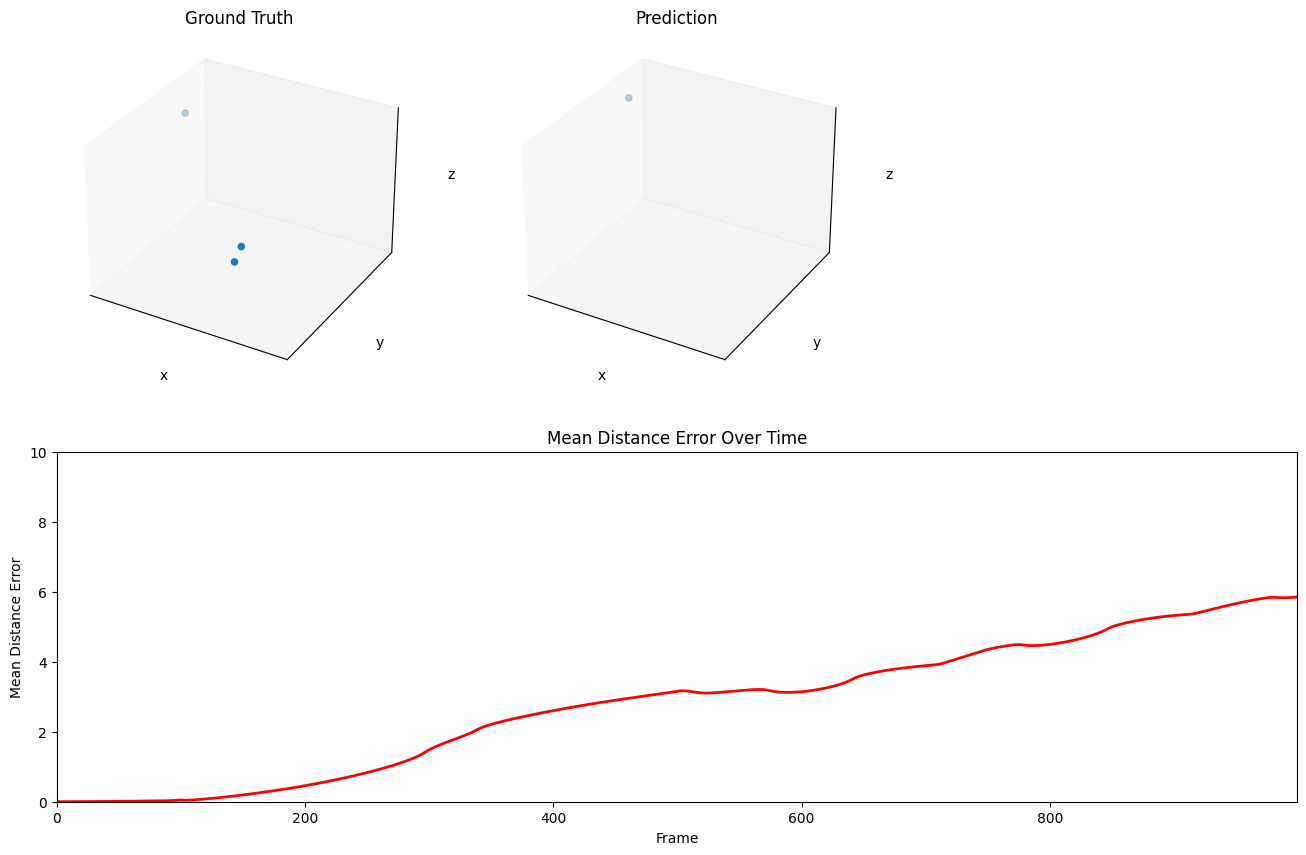

In [ ]:
from datagen import generate_n_body_scene
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# animate the scene in 3d comparing the predicted scene with the actual scene
def get_new_pos_vel(acc, pos, vel, dt=0.01):
    new_vel = vel + acc * dt
    new_pos = pos + new_vel * dt
    return new_pos, new_vel

def sim_accelerations(positions, masses, G=1.0, softening=0.1):
    x = positions[:, 0:1]
    y = positions[:, 1:2]
    z = positions[:, 2:3]
    
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
    inv_r3[inv_r3 > 0] = inv_r3[inv_r3 > 0]**(-1.5)
    
    ax = G * (dx * inv_r3) @ masses
    ay = G * (dy * inv_r3) @ masses
    az = G * (dz * inv_r3) @ masses

    return np.hstack((ax, ay, az))

def generate_rollout(model, scene, n_steps=1000, dt=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
    masses = torch.tensor(scene['masses']).unsqueeze(-1)
    positions = torch.tensor(scene['frames'][0]['pos'])
    velocities = torch.tensor(scene['frames'][0]['vel'])
    Gs = torch.ones_like(masses)
    softening = torch.ones_like(masses) * 0.1
    features = torch.cat([positions, velocities, Gs, softening, masses], dim=-1)
    graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, RADIUS)
    graph_data = graph_data.to(device)
    pos_pred = []
    acc_pred = []
    model.eval()
    with torch.no_grad():
        for i in range(n_steps):
            out = model(graph_data)
            acc = out.cpu().numpy()
            acc_pred.append(acc)
            new_pos, new_vel = get_new_pos_vel(acc, positions, velocities, dt=dt)
            new_feats = torch.cat([new_pos, new_vel, Gs, softening, masses], dim=-1)
            graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(new_feats, new_pos, RADIUS)
            graph_data = create_edge_attributes_based_on_mass_and_dist(graph_data)
            positions = new_pos
            velocities = new_vel
            pos_pred.append(new_pos)
            graph_data = graph_data.to(device)
    return np.array(pos_pred), np.array(acc_pred)

def generate_rollout_mixed(model, scene, n_steps=1000, dt=0.01, model_percentage=0.5):

    
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
    masses = torch.tensor(scene['masses']).unsqueeze(-1)
    positions = torch.tensor(scene['frames'][0]['pos'])
    velocities = torch.tensor(scene['frames'][0]['vel'])
    Gs = torch.ones_like(masses)
    softening = torch.ones_like(masses) * 0.1
    features = torch.cat([positions, velocities, Gs, softening, masses], dim=-1)
    graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, RADIUS)
    graph_data = graph_data.to(device)
    pos_pred = []
    acc_pred = []
    model.eval()
    with torch.no_grad():
        for i in range(n_steps):
            if np.random.rand() < model_percentage:
                out = model(graph_data)
                acc = out.cpu().numpy()
            else:
                acc = sim_accelerations(positions.numpy(), masses.numpy())
            acc_pred.append(acc)
            new_pos, new_vel = get_new_pos_vel(acc, positions, velocities, dt=dt)
            new_feats = torch.cat([new_pos, new_vel, Gs, softening, masses], dim=-1)
            graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(new_feats, new_pos, RADIUS)
            graph_data = create_edge_attributes_based_on_mass_and_dist(graph_data)
            positions = new_pos
            velocities = new_vel
            pos_pred.append(new_pos)
            graph_data = graph_data.to(device)
    return np.array(pos_pred), np.array(acc_pred)


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch

def animate_scene(scene, pos_pred):
    # Create a 2D animation with a line plot below
    fig = plt.figure(figsize=(16, 10))

    # 3D scatter plot for Ground Truth
    ax1 = fig.add_subplot(231, projection='3d')
    ax1.set_xlim(-2, 2)
    ax1.set_ylim(-2, 2)
    ax1.set_zlim(-2, 2)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax1.set_title('Ground Truth')

    # 3D scatter plot for Prediction
    ax2 = fig.add_subplot(232, projection='3d')
    ax2.set_xlim(-2, 2)
    ax2.set_ylim(-2, 2)
    ax2.set_zlim(-2, 2)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('z')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2.set_title('Prediction')

    # Line plot for mean distance error over time
    ax3 = fig.add_subplot(212)
    ax3.set_xlim(0, len(pos_pred) - 1)
    ax3.set_ylim(0, 10)
    ax3.set_xlabel('Frame')
    ax3.set_ylabel('Mean Distance Error')
    ax3.set_title('Mean Distance Error Over Time')
    line, = ax3.plot([], [], color='r', lw=2)

    # Prepare the data
    n_bodies = len(scene['masses'])
    gt_pos = np.array([frame['pos'] for frame in scene['frames']])
    scat1 = ax1.scatter(gt_pos[0, :, 0], gt_pos[0, :, 1], gt_pos[0, :, 2], color='r')
    scat2 = ax2.scatter(pos_pred[0, :, 0], pos_pred[0, :, 1], pos_pred[0, :, 2], color='b')

    # Calculate mean distances for each frame
    mean_distance_per_step = [
        mean_distance(torch.tensor(pos_pred[i]), torch.tensor(gt_pos[i])).item()
        for i in range(len(pos_pred))
    ]

    # Update function for animation
    def update(frame):
        # Update 3D scatter plots
        scat1._offsets3d = (gt_pos[frame, :, 0], gt_pos[frame, :, 1], gt_pos[frame, :, 2], color='r')
        scat2._offsets3d = (pos_pred[frame, :, 0], pos_pred[frame, :, 1], pos_pred[frame, :, 2], color='b')

        # Update line plot with error values up to current frame
        line.set_data(np.arange(frame + 1), mean_distance_per_step[:frame + 1], color='g')
        
        return scat1, scat2, line

    # Create animation
    anim = FuncAnimation(fig, update, frames=len(pos_pred), blit=True, interval=10)

    return anim, mean_distance_per_step



scene = generate_n_body_scene(n_bodies=3)
pos_pred, acc_pred = generate_rollout_mixed(model, scene, n_steps=1000, dt=0.01, model_percentage=1)
ani, mean_dist = animate_scene(scene, pos_pred)
HTML(ani.to_html5_video())